### Preprocesamiento de los Datos

- Se eliminaron valores nulos si existían (aunque el dataset no los tenía).
- Se aplicó `StandardScaler` para normalizar.
- Se usó `pd.get_dummies()` para variables categóricas.
- Se dividieron los datos en 80% entrenamiento y 20% prueba.

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

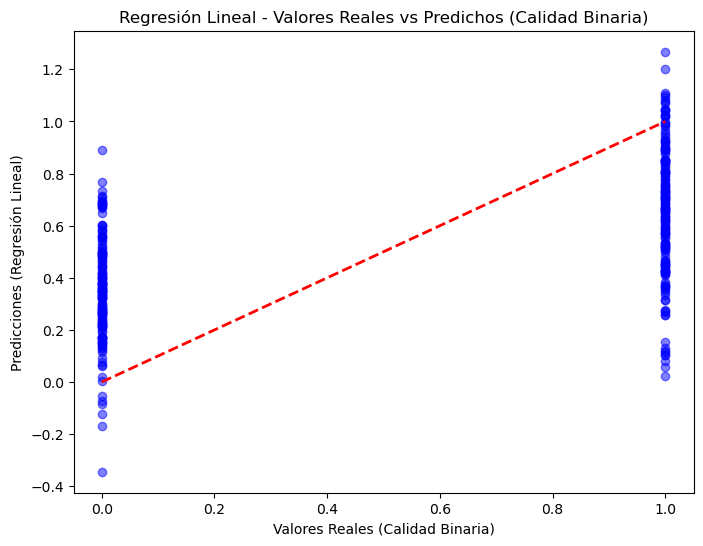

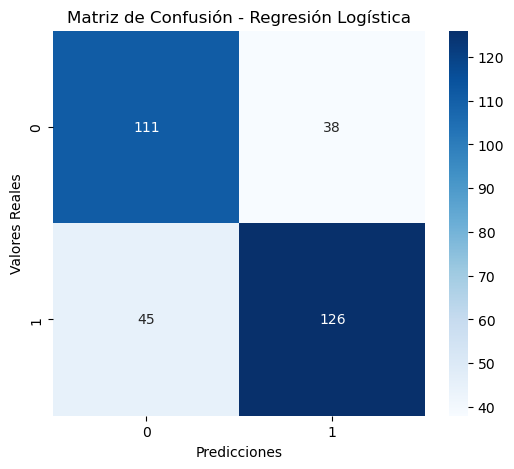

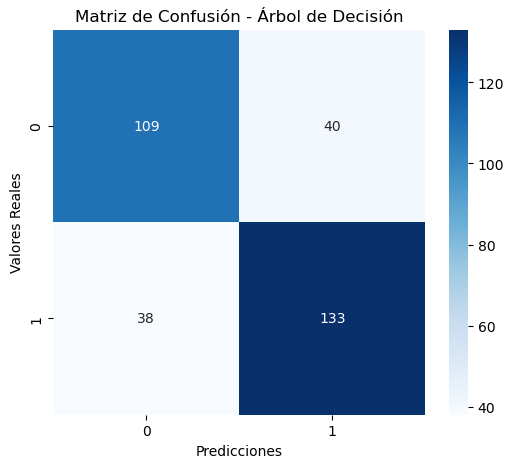

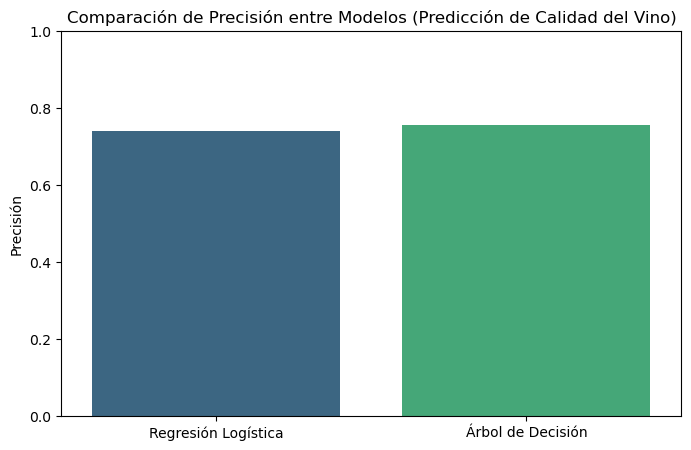

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.impute import SimpleImputer

df = pd.read_csv("winequality-red.csv", sep=',')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df.head())
print("\nNombres de las columnas en el DataFrame:")
print(df.columns)

df = pd.get_dummies(df, drop_first=True)

df['quality_binary'] = (df['quality'] >= 6).astype(int)
y = df['quality_binary']
X = df.drop(columns=['quality', 'quality_binary'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y) 
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)
y_pred_lineal = modelo_lineal.predict(X_test)

# Elimina la segunda binarización

y_train_bin = y_train # Usa la variable ya binarizada para el entrenamiento
y_test_bin = y_test   # Usa la variable ya binarizada para la prueba

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train_bin, y_train_bin)
y_pred_logistico = modelo_logistico.predict(X_test_bin)

modelo_arbol = DecisionTreeRegressor(random_state=42) 
modelo_arbol.fit(X_train, y_train)
y_pred_arbol = modelo_arbol.predict(X_test)
y_pred_arbol_bin = (y_pred_arbol >= 0.5).astype(int) 

print("\nModelo entrenado con éxito")

# 🔹 Evaluación de los Modelos
print("🔹 Evaluación Regresión Lineal")
print("R^2 Score:", modelo_lineal.score(X_test, y_test))
from sklearn.metrics import mean_squared_error
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lineal))


print("\n🔹 Evaluación Regresión Logística")
print("Accuracy:", accuracy_score(y_test_bin, y_pred_logistico))
print(classification_report(y_test_bin, y_pred_logistico))

cm_log_df = confusion_matrix(y_test_bin, y_pred_logistico)
specificity_log_df = cm_log_df[0, 0] / (cm_log_df[0, 0] + cm_log_df[0, 1])
print("Specificity (Regresión Logística - df):", round(specificity_log_df, 4)) 

# Convertir predicciones del árbol de decisión a binario
# y_pred_arbol_bin = (y_pred_arbol > y.median()).astype(int) # Ya se hizo arriba

print("\n🔹 Evaluación Árbol de Decisión")
print("Accuracy:", accuracy_score(y_test_bin, y_pred_arbol_bin))
print(classification_report(y_test_bin, y_pred_arbol_bin))

cm_arbol_df = confusion_matrix(y_test_bin, y_pred_arbol_bin)
specificity_arbol_df = cm_arbol_df[0, 0] / (cm_arbol_df[0, 0] + cm_arbol_df[0, 1])
print("Specificity (Árbol de Decisión - df):", round(specificity_arbol_df, 4))

# Gráfico de dispersión para Regresión Lineal
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lineal, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Línea de referencia perfecta
plt.xlabel("Valores Reales (Calidad Binaria)")
plt.ylabel("Predicciones (Regresión Lineal)")
plt.title("Regresión Lineal - Valores Reales vs Predichos (Calidad Binaria)")
plt.show()

# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.title(title)
    plt.show()

# Graficar matrices de confusión
plot_confusion_matrix(y_test_bin, y_pred_logistico, "Matriz de Confusión - Regresión Logística")
plot_confusion_matrix(y_test_bin, y_pred_arbol_bin, "Matriz de Confusión - Árbol de Decisión")

# Crear un diccionario con las métricas de cada modelo
modelos = ["Regresión Logística", "Árbol de Decisión"]
accuracy_scores = [accuracy_score(y_test_bin, y_pred_logistico), accuracy_score(y_test_bin, y_pred_arbol_bin)]

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=modelos, y=accuracy_scores, hue=modelos, palette="viridis", legend=False)
plt.ylim(0, 1)
plt.ylabel("Precisión")
plt.title("Comparación de Precisión entre Modelos (Predicción de Calidad del Vino)")
plt.show()
